In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df = pd.read_csv('SeaPlaneTravel.csv', index_col='Month',parse_dates=['Month'])
dataparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = df
ts.head()

,Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121


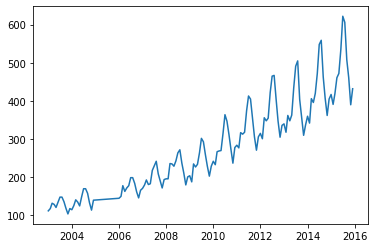

In [30]:
#This cell is not necessary, ignore it.
df1= pd.read_csv('SeaPlaneTravel.csv')
df1['Month'] = pd.to_datetime(df1['Month'])
indexed_df = df1.set_index('Month')
ts1 = indexed_df['Passengers']
ts1.head(5)
plt.plot(ts1)

C:\Users\Lenovo lap\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


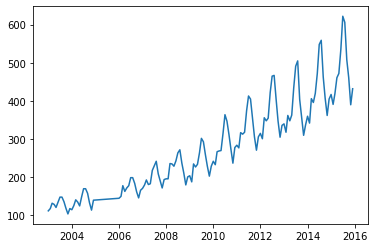

In [4]:
plt.plot(ts)

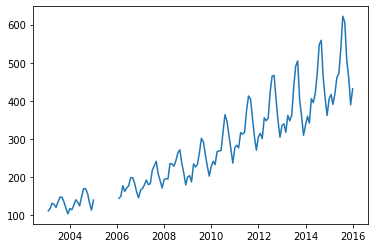

In [5]:
ts_month = ts.resample('M').mean()
plt.plot(ts_month)

In [6]:
ts

,Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121
...,...
2015-08-01,606
2015-09-01,508
2015-10-01,461


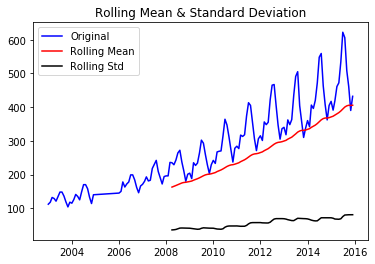

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts['Passengers'])

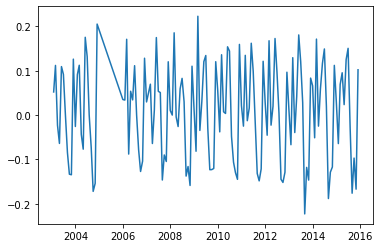

In [8]:
ts_month_log = np.log(ts)
ts_month_log_diff = ts_month_log - ts_month_log.shift()
plt.plot(ts_month_log_diff)

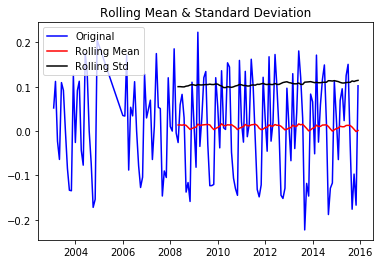

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [11]:
ts_month_log_diff.dropna(inplace=True)
test_stationarity(ts_month_log_diff['Passengers'])

In [13]:
#ACF and PACF
lag_acf = acf(ts_month_log_diff, nlags=10)
lag_pacf = pacf(ts_month_log_diff, nlags=10, method='ols')

C:\Users\Lenovo lap\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

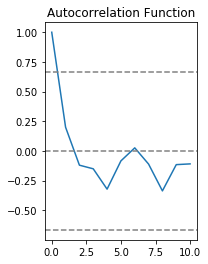

In [14]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

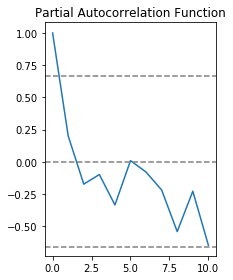

In [15]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Lenovo lap\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo lap\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


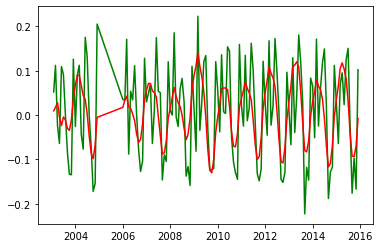

In [16]:
model = ARIMA(ts_month_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_month_log_diff, color='green')
plt.plot(results_ARIMA.fittedvalues, color='red')

In [17]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head(20) )

Month
2003-02-01    0.009580
2003-03-01    0.017491
2003-04-01    0.027670
2003-05-01   -0.004521
2003-06-01   -0.023890
2003-07-01   -0.004347
2003-08-01   -0.010978
2003-09-01   -0.029929
2003-10-01   -0.034467
2003-11-01   -0.011279
2003-12-01    0.037212
2004-01-01    0.068135
2004-02-01    0.089434
2004-03-01    0.090029
2004-04-01    0.066152
2004-05-01    0.044053
2004-06-01    0.035467
2004-07-01    0.003100
2004-08-01   -0.047127
2004-09-01   -0.086353
dtype: float64


In [18]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head(20) )

Month
2003-02-01    0.009580
2003-03-01    0.027071
2003-04-01    0.054742
2003-05-01    0.050221
2003-06-01    0.026331
2003-07-01    0.021984
2003-08-01    0.011007
2003-09-01   -0.018922
2003-10-01   -0.053389
2003-11-01   -0.064668
2003-12-01   -0.027456
2004-01-01    0.040679
2004-02-01    0.130113
2004-03-01    0.220143
2004-04-01    0.286294
2004-05-01    0.330348
2004-06-01    0.365815
2004-07-01    0.368915
2004-08-01    0.321788
2004-09-01    0.235435
dtype: float64


In [23]:
ts_month_log

,Passengers
Month,
2003-01-01,4.718499
2003-02-01,4.770685
2003-03-01,4.882802
2003-04-01,4.859812
2003-05-01,4.795791
...,...
2015-08-01,6.406880
2015-09-01,6.230481
2015-10-01,6.133398


In [25]:
predictions_ARIMA_log = pd.Series(ts_month_log.iloc[:,0], index=ts_month_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
2003-01-01    4.718499
2003-02-01    4.780265
2003-03-01    4.909873
2003-04-01    4.914554
2003-05-01    4.846011
dtype: float64

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA.head())

Month
2003-01-01    112.000000
2003-02-01    119.135879
2003-03-01    135.622239
2003-04-01    136.258538
2003-05-01    127.231893
dtype: float64


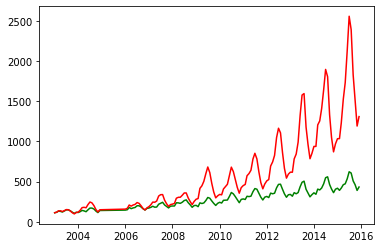

In [27]:
plt.plot(ts, color='green')
plt.plot(predictions_ARIMA,color='red')